In [1]:
#Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
df=pd.read_csv("GiaSMP_TS.csv")
ss=pd.read_csv("sample_submission.csv")

In [6]:
feats= ['3']

In [8]:
transformer = PowerTransformer()
X=transformer.fit_transform(df[feats])

In [17]:
pca = PCA(n_components=0.5,random_state=1)
pca.fit(X)
PCA_ds = pd.DataFrame(pca.transform(df[feats]), columns=(["col"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col,365.0,-1040.229041,105.146791,-1565.5,-1061.5,-1022.6,-988.4,-885.7


Elbow Method to determine the number of clusters to be formed:


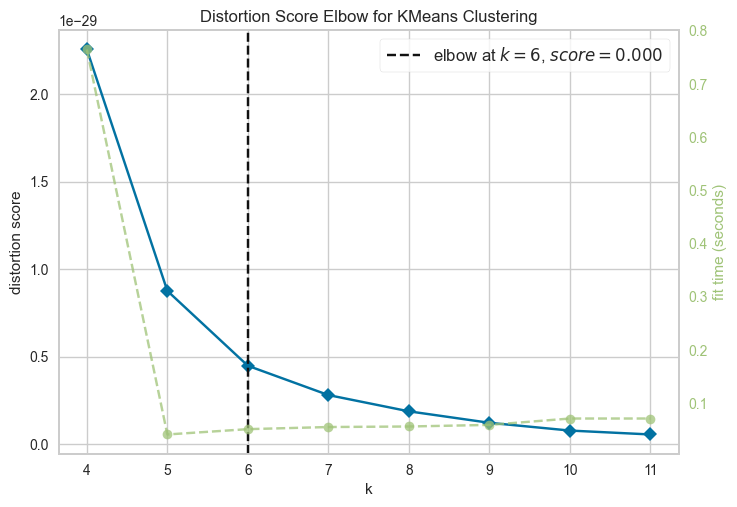

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(random_state=23), k=(4,12))
Elbow_M.fit(X)
Elbow_M.show()

In [22]:
BGM = BayesianGaussianMixture(n_components=7,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
preds = BGM.fit_predict(X)
PCA_ds["Clusters"] = preds
#Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= preds

In [23]:
pp=BGM.predict_proba(X)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(X,columns=feats) 
df_new[[f'predict_proba_{i}' for i in range(7)]]=pp # creating new dataframe columns of probabilites 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(7):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [24]:
#ricopue's notebook's code snippet
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15


In [25]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [26]:
labels=np.argmax(lgb_preds,axis=1)

In [29]:
ss.Predicted=np.argmax(lgb_preds,axis=1)

ValueError: Length of values (365) does not match length of index (98000)

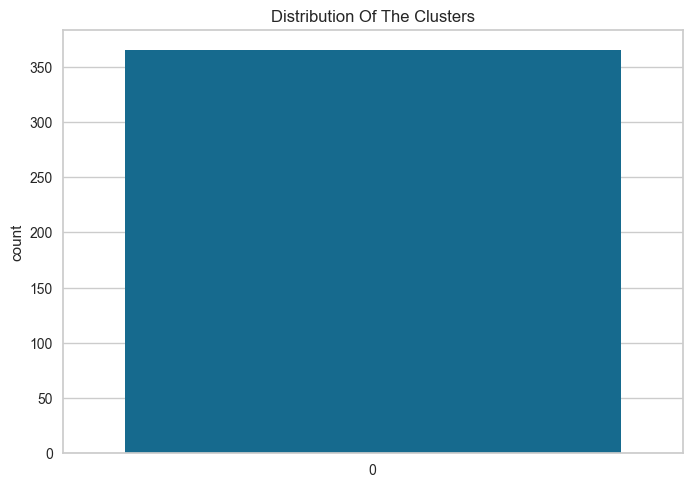

In [30]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()

In [31]:
ss.to_csv("submission.csv",index=False)